# LightGBM


## 1.导入相关库

In [333]:
import numpy as np
import pandas as pd

#preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

#visualizations
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#algorithms
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier

#score metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score



## 2.读取数据

In [334]:
# path = '/home/kesci/data/competition_A/'
path = './data/competition_A/'
train_df = pd.read_csv(path+'train_set.csv')
test_df  = pd.read_csv(path+'test_set.csv')
submission  =  pd.read_csv(path+'submission_example.csv')
print('Train Shape:{}\nTest Shape:{}'.format(train_df.shape,test_df.shape))
train_df.head(5)


Train Shape:(6000, 31)
Test Shape:(2785, 30)


,年龄,性别,区域,体重,身高,体重指数,肥胖腰围,腰围,最高血压,最低血压,好胆固醇,坏胆固醇,总胆固醇,血脂异常,PVD,体育活动,教育,未婚,收入,护理来源,视力不佳,饮酒,高血压,家庭高血压,糖尿病,家族糖尿病,肝炎,家族肝炎,慢性疲劳,ALF,ID
0,58,F,east,75.6,174.9,24.71,0.0,94.8,100.0,52.0,35.0,95.0,130.0,0,0,1.0,0.0,0.0,0.0,Private Hospital,0.0,0,1.0,1,0,1,1.0,0.0,1.0,0.0,4379
1,85,F,east,66.3,166.1,24.03,0.0,89.6,134.0,84.0,59.0,153.0,212.0,0,0,2.0,0.0,0.0,0.0,Private Hospital,0.0,1,0.0,0,0,0,0.0,0.0,0.0,NaN,7623
2,32,F,east,109.9,173.2,36.64,1.0,111.7,124.0,84.0,39.0,133.0,172.0,0,0,2.0,1.0,0.0,1.0,Private Hospital,0.0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,1764
3,22,M,east,58.7,171.3,20.00,0.0,78.0,104.0,56.0,48.0,98.0,146.0,0,0,2.0,1.0,1.0,0.0,Never Counsulted,0.0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,5450
4,44,F,west,79.7,172.1,26.91,0.0,93.8,114.0,60.0,34.0,195.0,229.0,0,0,2.0,0.0,0.0,0.0,Private Hospital,0.0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,5196


## 3.数据分析EDA


### 3.1 各列与肝炎的关系

#### 3.1.1 年龄与肝炎

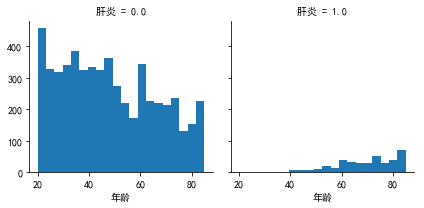

In [335]:
g = sns.FacetGrid(train_df, col='肝炎')
g.map(plt.hist, '年龄', bins=20)

#### 3.1.2 体重指数与肝炎

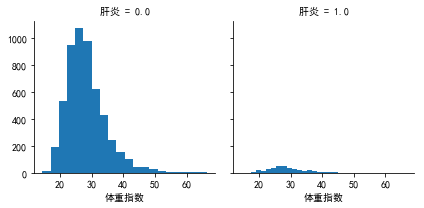

In [336]:
g = sns.FacetGrid(train_df, col='肝炎')
g.map(plt.hist, '体重指数', bins=20)

#### 3.1.3 ALF与肝炎

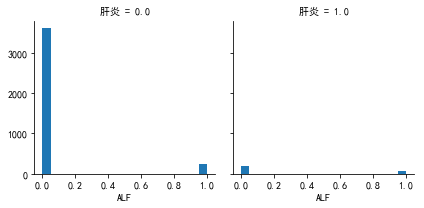

In [337]:
g = sns.FacetGrid(train_df, col='肝炎')
g.map(plt.hist, 'ALF', bins=20)


### 3.2 删除无关列

In [338]:
train_df.drop(['ALF'], axis=1, inplace=True)
test_df.drop(['ALF'], axis=1, inplace=True)

train_df.head()

,年龄,性别,区域,体重,身高,体重指数,肥胖腰围,腰围,最高血压,最低血压,好胆固醇,坏胆固醇,总胆固醇,血脂异常,PVD,体育活动,教育,未婚,收入,护理来源,视力不佳,饮酒,高血压,家庭高血压,糖尿病,家族糖尿病,肝炎,家族肝炎,慢性疲劳,ID
0,58,F,east,75.6,174.9,24.71,0.0,94.8,100.0,52.0,35.0,95.0,130.0,0,0,1.0,0.0,0.0,0.0,Private Hospital,0.0,0,1.0,1,0,1,1.0,0.0,1.0,4379
1,85,F,east,66.3,166.1,24.03,0.0,89.6,134.0,84.0,59.0,153.0,212.0,0,0,2.0,0.0,0.0,0.0,Private Hospital,0.0,1,0.0,0,0,0,0.0,0.0,0.0,7623
2,32,F,east,109.9,173.2,36.64,1.0,111.7,124.0,84.0,39.0,133.0,172.0,0,0,2.0,1.0,0.0,1.0,Private Hospital,0.0,0,0.0,0,0,0,0.0,0.0,0.0,1764
3,22,M,east,58.7,171.3,20.00,0.0,78.0,104.0,56.0,48.0,98.0,146.0,0,0,2.0,1.0,1.0,0.0,Never Counsulted,0.0,0,0.0,0,0,0,0.0,0.0,0.0,5450
4,44,F,west,79.7,172.1,26.91,0.0,93.8,114.0,60.0,34.0,195.0,229.0,0,0,2.0,0.0,0.0,0.0,Private Hospital,0.0,0,0.0,0,0,0,0.0,0.0,0.0,5196


### 3.2 查询数据缺失值

In [339]:
total_missingvalues = train_df.isnull().sum()
total_missingvalues

年龄         0
性别         0
区域         0
体重       140
身高       136
体重指数     209
肥胖腰围     209
腰围       224
最高血压     219
最低血压     273
好胆固醇       6
坏胆固醇       7
总胆固醇       7
血脂异常       0
PVD        0
体育活动       8
教育        14
未婚       308
收入       763
护理来源       1
视力不佳     402
饮酒         0
高血压       49
家庭高血压      0
糖尿病        0
家族糖尿病      0
肝炎        16
家族肝炎       5
慢性疲劳      26
ID         0
dtype: int64

In [340]:
# 删除肝炎缺失值的行

train_df.dropna(axis=0, how='any', subset=['肝炎'], inplace=True)

train_df.isnull().sum()

年龄         0
性别         0
区域         0
体重       139
身高       135
体重指数     207
肥胖腰围     207
腰围       223
最高血压     219
最低血压     273
好胆固醇       5
坏胆固醇       6
总胆固醇       6
血脂异常       0
PVD        0
体育活动       8
教育        13
未婚       308
收入       760
护理来源       1
视力不佳     399
饮酒         0
高血压       49
家庭高血压      0
糖尿病        0
家族糖尿病      0
肝炎         0
家族肝炎       5
慢性疲劳      23
ID         0
dtype: int64

In [341]:
# One-hot编码
train_df = pd.get_dummies(train_df)
test_df = pd.get_dummies(test_df)

train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

train_df.head(5)

,年龄,体重,身高,体重指数,肥胖腰围,腰围,最高血压,最低血压,好胆固醇,坏胆固醇,总胆固醇,血脂异常,PVD,体育活动,教育,未婚,收入,视力不佳,饮酒,高血压,家庭高血压,糖尿病,家族糖尿病,肝炎,家族肝炎,慢性疲劳,ID,性别_F,性别_M,区域_east,区域_north,区域_south,区域_west,护理来源_Governament Hospital,护理来源_Never Counsulted,护理来源_Private Hospital,护理来源_clinic
0,58,75.6,174.9,24.71,0.0,94.8,100.0,52.0,35.0,95.0,130.0,0,0,1.0,0.0,0.0,0.0,0.0,0,1.0,1,0,1,1.0,0.0,1.0,4379,1,0,1,0,0,0,0,0,1,0
1,85,66.3,166.1,24.03,0.0,89.6,134.0,84.0,59.0,153.0,212.0,0,0,2.0,0.0,0.0,0.0,0.0,1,0.0,0,0,0,0.0,0.0,0.0,7623,1,0,1,0,0,0,0,0,1,0
2,32,109.9,173.2,36.64,1.0,111.7,124.0,84.0,39.0,133.0,172.0,0,0,2.0,1.0,0.0,1.0,0.0,0,0.0,0,0,0,0.0,0.0,0.0,1764,1,0,1,0,0,0,0,0,1,0
3,22,58.7,171.3,20.00,0.0,78.0,104.0,56.0,48.0,98.0,146.0,0,0,2.0,1.0,1.0,0.0,0.0,0,0.0,0,0,0,0.0,0.0,0.0,5450,0,1,1,0,0,0,0,1,0,0
4,44,79.7,172.1,26.91,0.0,93.8,114.0,60.0,34.0,195.0,229.0,0,0,2.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0,0.0,0.0,0.0,5196,1,0,0,0,0,1,0,0,1,0


### 3.1 根据训练集的列可以得到大致如下三种特征：数字列、二值列（0或1）、字符列

In [342]:
# 数字列
num_columns = ['年龄','体重','身高','体重指数', '腰围', '最高血压', '最低血压',
                '好胆固醇', '坏胆固醇', '总胆固醇','收入']
# # 二值列
# zero_to_one_columns = ['肥胖腰围','血脂异常','PVD']
#
# # 字符列
# str_columns = ['性别','区域','体育活动','教育','未婚','护理来源','视力不佳','饮酒','高血压',
#                 '家庭高血压', '糖尿病', '家族糖尿病','家族肝炎', '慢性疲劳','ALF']
#

### 3.2 特征工程

In [343]:
# 处理缺失值
# train_df.fillna(0, inplace=True)
# test_df.fillna(0, inplace=True)


# One-hot编码
# train_df = pd.get_dummies(train_df)
# test_df = pd.get_dummies(test_df)
#

# # 字符编码
# for i in tqdm(str_columns):
#     lbl = LabelEncoder()
#     train_df[i] = lbl.fit_transform(train_df[i].astype(str))
#     test_df[i] = lbl.fit_transform(test_df[i].astype(str))
#
features = num_columns
# #
# # 数值归一化
train_df[features] = MinMaxScaler().fit_transform(train_df[features])
test_df[features] = MinMaxScaler().fit_transform(test_df[features])

train_df.head(5)

,年龄,体重,身高,体重指数,肥胖腰围,腰围,最高血压,最低血压,好胆固醇,坏胆固醇,总胆固醇,血脂异常,PVD,体育活动,教育,未婚,收入,视力不佳,饮酒,高血压,家庭高血压,糖尿病,家族糖尿病,肝炎,家族肝炎,慢性疲劳,ID,性别_F,性别_M,区域_east,区域_north,区域_south,区域_west,护理来源_Governament Hospital,护理来源_Never Counsulted,护理来源_Private Hospital,护理来源_clinic
0,0.584615,0.395604,0.874063,0.371915,0.0,0.571084,0.429185,0.393939,0.21875,0.138889,0.178817,0,0,1.0,0.0,0.0,0.0,0.0,0,1.0,1,0,1,1.0,0.0,1.0,4379,1,0,1,0,0,0,0,0,1,0
1,1.000000,0.346939,0.830085,0.361680,0.0,0.539759,0.575107,0.636364,0.36875,0.223684,0.291609,0,0,2.0,0.0,0.0,0.0,0.0,1,0.0,0,0,0,0.0,0.0,0.0,7623,1,0,1,0,0,0,0,0,1,0
2,0.184615,0.575092,0.865567,0.551475,1.0,0.672892,0.532189,0.636364,0.24375,0.194444,0.236589,0,0,2.0,1.0,0.0,1.0,0.0,0,0.0,0,0,0,0.0,0.0,0.0,1764,1,0,1,0,0,0,0,0,1,0
3,0.030769,0.307169,0.856072,0.301023,0.0,0.469880,0.446352,0.424242,0.30000,0.143275,0.200825,0,0,2.0,1.0,1.0,0.0,0.0,0,0.0,0,0,0,0.0,0.0,0.0,5450,0,1,1,0,0,0,0,1,0,0
4,0.369231,0.417059,0.860070,0.405027,0.0,0.565060,0.489270,0.454545,0.21250,0.285088,0.314993,0,0,2.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0,0.0,0.0,0.0,5196,1,0,0,0,0,1,0,0,1,0


## 4.模型



### 4.1 准备数据集

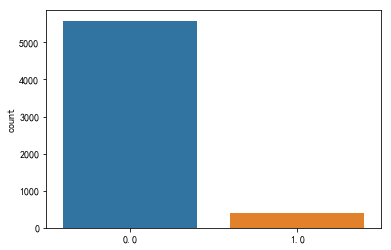

Before OverSampling, counts of label '1': 402
Before OverSampling, counts of label '0': 5582 



In [344]:
all_columns = [i for i in train_df.columns if i not in ['肝炎','ID']]

cols = all_columns

train_x, train_y = train_df[all_columns].to_numpy(), train_df['肝炎'].values
test_x  = test_df[all_columns].values




submission['hepatitis'] = 0

# 绘制计数直方图
sns.countplot(train_y)
plt.show()

print("Before OverSampling, counts of label '1': {}".format(sum(train_y==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(train_y==0)))

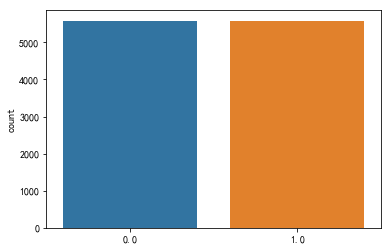

After OverSampling, counts of label '1': 5582
After OverSampling, counts of label '0': 5582


In [345]:
sm = SMOTE(random_state=2)
train_x, train_y = sm.fit_sample(train_x, train_y.ravel())

# 绘制计数直方图
sns.countplot(train_y)
plt.show()

print("After OverSampling, counts of label '1': {}".format(sum(train_y==1)))
print("After OverSampling, counts of label '0': {}".format(sum(train_y==0)))

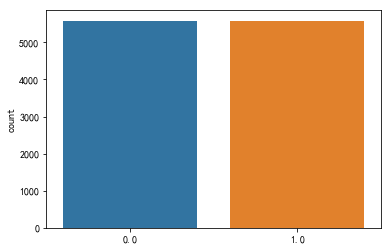

After OverSampling, counts of label '1': 5582
After OverSampling, counts of label '0': 5582


In [346]:
sm = SMOTE(random_state=2)
train_x, train_y = sm.fit_sample(train_x, train_y.ravel())

# 绘制计数直方图
sns.countplot(train_y)
plt.show()

print("After OverSampling, counts of label '1': {}".format(sum(train_y==1)))
print("After OverSampling, counts of label '0': {}".format(sum(train_y==0)))


### 4.2 训练模型

In [347]:
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.2)

train_data=lgb.Dataset(X_train, label=y_train)
valid_data=lgb.Dataset(X_val, label=y_val)


params = {'metric' : 'auc',
          'boosting_type' : 'gbdt',
          'objective' : 'binary',
          'colsample_bytree' : 0.9234,
          'num_leaves' : 13,
          'max_depth' : -1,
          'n_estimators' : 1000,
          'min_child_samples': 399,
          'min_child_weight': 0.1,
          'reg_alpha': 2,
          'reg_lambda': 5,
          'subsample': 0.855,
          'verbose' : -1,
          'num_threads' : 4
}

lgbm = lgb.train(params,
                 train_data,
                 valid_sets=valid_data,
                 early_stopping_rounds= 100,
                 verbose_eval=10
                 )

result = []

Y_valid_pred_prob = lgbm.predict(X_val)
result.append(roc_auc_score(y_val, Y_valid_pred_prob))
submission['hepatitis'] += lgbm.predict(test_x)

print(result)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.917587
[20]	valid_0's auc: 0.942304
[30]	valid_0's auc: 0.959019
[40]	valid_0's auc: 0.971812
[50]	valid_0's auc: 0.980782
[60]	valid_0's auc: 0.986621
[70]	valid_0's auc: 0.989294
[80]	valid_0's auc: 0.991269
[90]	valid_0's auc: 0.992336
[100]	valid_0's auc: 0.993001
[110]	valid_0's auc: 0.993382
[120]	valid_0's auc: 0.993863
[130]	valid_0's auc: 0.994141
[140]	valid_0's auc: 0.994355
[150]	valid_0's auc: 0.994439
[160]	valid_0's auc: 0.994611
[170]	valid_0's auc: 0.994719
[180]	valid_0's auc: 0.994743
[190]	valid_0's auc: 0.994817
[200]	valid_0's auc: 0.994862
[210]	valid_0's auc: 0.994969
[220]	valid_0's auc: 0.994952
[230]	valid_0's auc: 0.994978
[240]	valid_0's auc: 0.994968
[250]	valid_0's auc: 0.995034
[260]	valid_0's auc: 0.995029
[270]	valid_0's auc: 0.995059
[280]	valid_0's auc: 0.995045
[290]	valid_0's auc: 0.995067
[300]	valid_0's auc: 0.995067
[310]	valid_0's auc: 0.995061
[320]	valid_0's 

Found `n_estimators` in params. Will use it instead of argument


In [348]:
submission.to_csv('submission.csv',index=False)
# !wget -nv -O kesci_submit https://cdn.kesci.com/submit_tool/v4/kesci_submit&&chmod +x kesci_submit
# !./kesci_submit -token f3de41fac72af731 -file '/home/kesci/work/submission.csv'

In [351]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(pd.DataFrame(X_train, columns=cols))

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


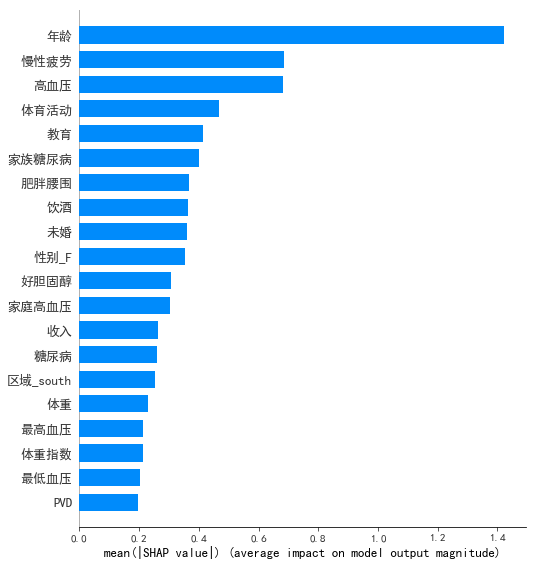

In [352]:
shap.summary_plot(shap_values[1], pd.DataFrame(X_train, columns=cols), plot_type='bar')
